In [1]:
import sys
import os
import warnings
warnings.filterwarnings('ignore')

sys.path.append('../')
from utils import (
    create_data_pipeline, 
    create_training_pipeline, 
    create_evaluation_pipeline,
    run_complete_experiment
)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)


In [2]:

EXPERIMENT_CONFIG = {
    'experiment_name': 'sentence_bert_LogisticRegression',
    'data_path': '../data/sofmattress_train.csv',
    'vectorizer_type': 'sentence_bert',        # 'tfidf', 'word2vec', 'glove', 'tfidf_weighted_word2vec','hybrid_tfidf_word2vec', 'char_ngram_tfidf','doc2vec','sentence_bert','universal_sentence_encoder'
    'model_name': 'logistic_regression', # 'logistic_regression', 'svm', 'random_forest', 'naive_bayes'
    'imbalance_method': 'class_weight',       # 'smote', 'random_oversample', 'class_weight', 'none'
    'tuning_method': 'grid',           # 'grid', 'random', 'none'
    'test_size': 0.2,
    'cv_folds': 5
}

print("Experiment Configuration:")
for key, value in EXPERIMENT_CONFIG.items():
    print(f"   {key}: {value}")


Experiment Configuration:
   experiment_name: sentence_bert_LogisticRegression
   data_path: ../data/sofmattress_train.csv
   vectorizer_type: sentence_bert
   model_name: logistic_regression
   imbalance_method: class_weight
   tuning_method: grid
   test_size: 0.2
   cv_folds: 5



📊 Dataset Overview:
   Total samples: 328
   Unique intents: 21
   Class distribution:
      DISTRIBUTORS: 34 samples
      EMI: 25 samples
      MATTRESS_COST: 22 samples
      LEAD_GEN: 21 samples
      PRODUCT_VARIANTS: 21 samples


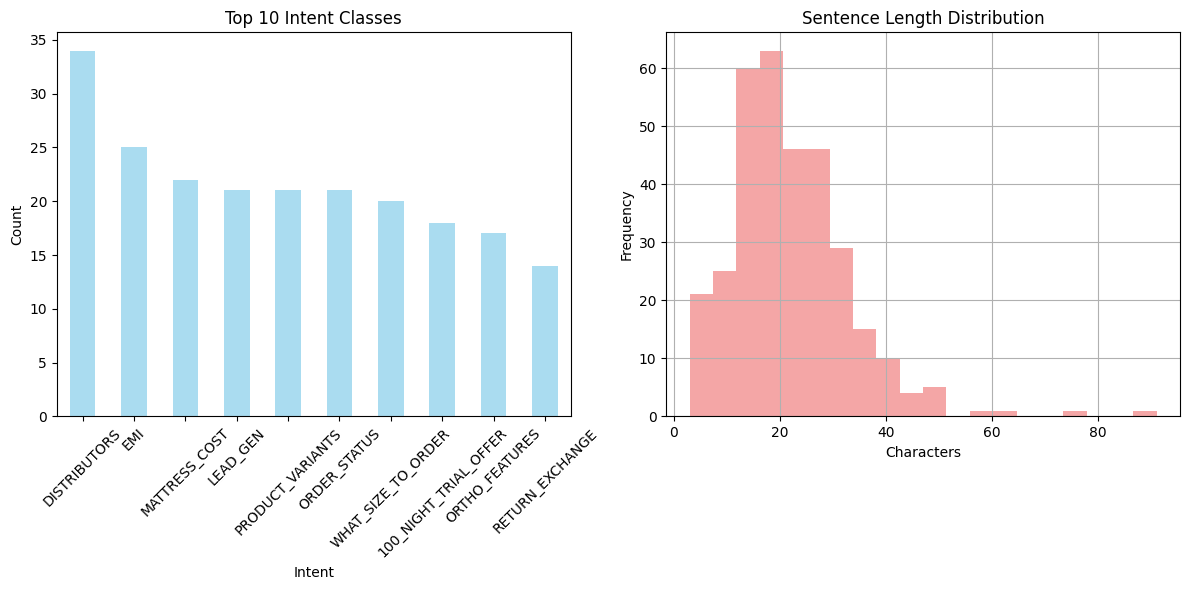

In [3]:
#Data Loading and EDA Review

data_path = EXPERIMENT_CONFIG['data_path']
df = pd.read_csv(data_path)

print(f"\n📊 Dataset Overview:")
print(f"   Total samples: {len(df)}")
print(f"   Unique intents: {df['label'].nunique()}")
print(f"   Class distribution:")

class_counts = df['label'].value_counts()
for intent, count in class_counts.head(5).items():
    print(f"      {intent}: {count} samples")

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
class_counts.head(10).plot(kind='bar', color='skyblue', alpha=0.7)
plt.title('Top 10 Intent Classes')
plt.xlabel('Intent')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
df['sentence'].str.len().hist(bins=20, color='lightcoral', alpha=0.7)
plt.title('Sentence Length Distribution')
plt.xlabel('Characters')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


In [4]:
# Data Processing
print("\n Setting up Data Processing Pipeline...")

data_pipeline = create_data_pipeline(
    vectorizer_type=EXPERIMENT_CONFIG['vectorizer_type']
)

X_train, X_test, y_train, y_test, train_texts, test_texts = data_pipeline.prepare_data(
    file_path=EXPERIMENT_CONFIG['data_path'],
    test_size=EXPERIMENT_CONFIG['test_size'],
    random_state=RANDOM_SEED
)

print(f" Data prepared successfully:")
print(f"   Training set: {X_train.shape}")
print(f"   Test set: {X_test.shape}")
print(f"   Feature dimensions: {X_train.shape[1]}")



 Setting up Data Processing Pipeline...


INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: mps
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2
INFO:utils.data_processing:Loaded Sentence-BERT model: all-MiniLM-L6-v2
INFO:utils.data_processing:DataPipeline initialized with sentence_bert vectorizer
INFO:utils.data_processing:Loaded 328 samples from ../data/sofmattress_train.csv
INFO:utils.data_processing:Found 21 unique classes
INFO:utils.data_processing:DataPipeline fitted successfully
Batches: 100%|██████████| 3/3 [00:00<00:00, 13.97it/s]
INFO:utils.data_processing:Data prepared: Train (262, 384), Test (66, 384)


 Data prepared successfully:
   Training set: (262, 384)
   Test set: (66, 384)
   Feature dimensions: 384


In [5]:
# Training Pipeline

print("\n Setting up Training Pipeline...")

# Create training pipeline
trainer = create_training_pipeline(random_state=RANDOM_SEED)

# Setup experiment
trainer.setup_experiment(
    experiment_name=EXPERIMENT_CONFIG['experiment_name'],
    model_name=EXPERIMENT_CONFIG['model_name'],
    imbalance_method=EXPERIMENT_CONFIG['imbalance_method'],
    tuning_method=EXPERIMENT_CONFIG['tuning_method']
)

# Train model
print("Training model (this may take a few minutes)...")
training_results = trainer.train_model(X_train, y_train, X_test, y_test)

print(f"Training completed:")
print(f"   Experiment ID: {training_results['experiment_id']}")
print(f"   Training time: {training_results['training_time']:.2f} seconds")
if training_results['best_params']:
    print(f"   Best parameters: {training_results['best_params']}")


INFO:utils.training:Experiment setup: sentence_bert_LogisticRegression
INFO:utils.training:Model: logistic_regression, Imbalance: class_weight, Tuning: grid
INFO:utils.training:Starting grid search with 3 parameters



 Setting up Training Pipeline...
Training model (this may take a few minutes)...
Fitting 5 folds for each of 8 candidates, totalling 40 fits


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Training completed:
   Experiment ID: exp_20250526_232014
   Training time: 1.41 seconds
   Best parameters: {'C': 100, 'class_weight': 'balanced', 'max_iter': 1000}



Model Evaluation...

🔍 EVALUATING: sentence_bert_LogisticRegression
📊 F1-SCORES:
   Macro F1 (Primary):    0.9146
   Micro F1:              0.9242
   Weighted F1:           0.9237
   Accuracy:              0.9242

📈 PER-CLASS PERFORMANCE:
   Best performing:  ABOUT_SOF_MATTRESS (F1: 1.0000)
   Worst performing: DELAY_IN_DELIVERY (F1: 0.6667)


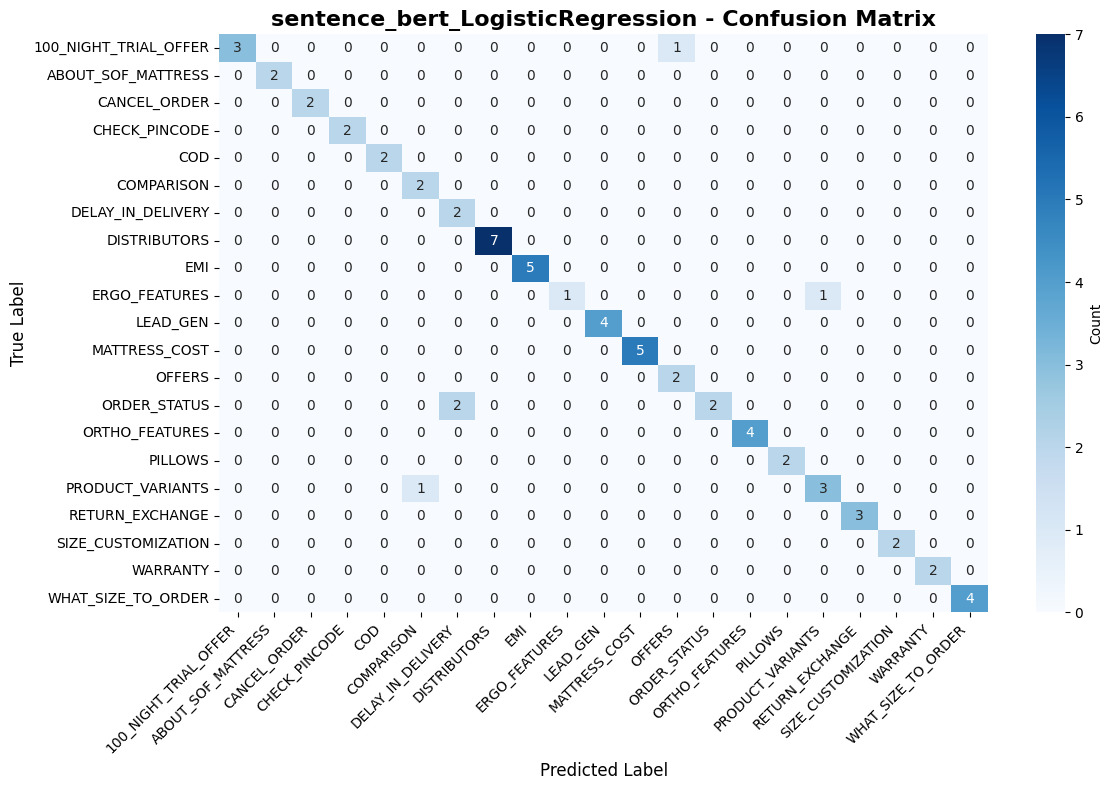

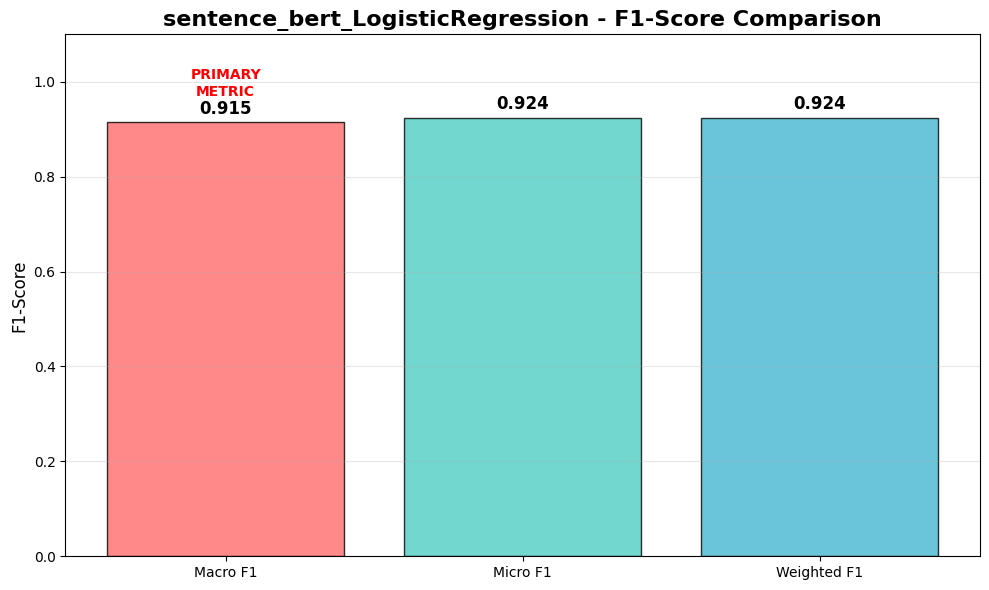

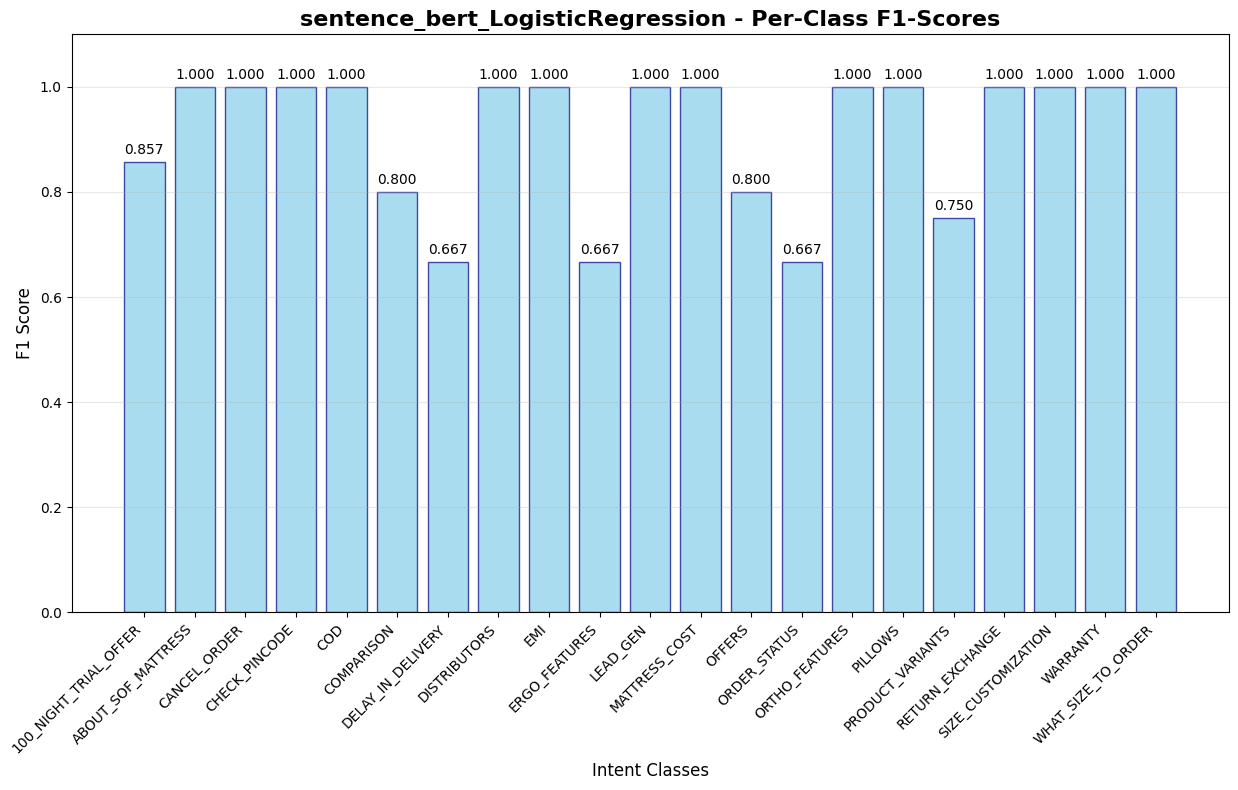


📋 DETAILED CLASSIFICATION REPORT:
--------------------------------------------------
                       precision    recall  f1-score   support

100_NIGHT_TRIAL_OFFER       1.00      0.75      0.86         4
   ABOUT_SOF_MATTRESS       1.00      1.00      1.00         2
         CANCEL_ORDER       1.00      1.00      1.00         2
        CHECK_PINCODE       1.00      1.00      1.00         2
                  COD       1.00      1.00      1.00         2
           COMPARISON       0.67      1.00      0.80         2
    DELAY_IN_DELIVERY       0.50      1.00      0.67         2
         DISTRIBUTORS       1.00      1.00      1.00         7
                  EMI       1.00      1.00      1.00         5
        ERGO_FEATURES       1.00      0.50      0.67         2
             LEAD_GEN       1.00      1.00      1.00         4
        MATTRESS_COST       1.00      1.00      1.00         5
               OFFERS       0.67      1.00      0.80         2
         ORDER_STATUS       1.0

In [6]:

# Model Evaluation

print("\nModel Evaluation...")

# Create evaluation pipeline
evaluator = create_evaluation_pipeline()

# Get unique class names
class_names = sorted(list(set(y_test)))

# Comprehensive evaluation
evaluation_results = evaluator.evaluate_model(
    model=training_results['model'],
    X_test=X_test,
    y_test=y_test,
    class_names=class_names,
    experiment_name=EXPERIMENT_CONFIG['experiment_name']
)



In [7]:

# Results Analysis

print("\nFINAL RESULTS SUMMARY")
print("=" * 50)

f1_scores = evaluation_results['f1_scores']
print(f"PRIMARY METRIC (Macro F1): {f1_scores['macro_f1']:.4f}")
print(f"Other F1 Scores:")
print(f"   Micro F1:    {f1_scores['micro_f1']:.4f}")
print(f"   Weighted F1: {f1_scores['weighted_f1']:.4f}")
print(f"   Accuracy:    {evaluation_results['accuracy']:.4f}")

# Performance insights
per_class_metrics = evaluation_results['per_class_metrics']
best_class = max(per_class_metrics.keys(), key=lambda x: per_class_metrics[x]['f1_score'])
worst_class = min(per_class_metrics.keys(), key=lambda x: per_class_metrics[x]['f1_score'])

print(f"\nPer-Class Insights:")
print(f"   Best performing:  {best_class} (F1: {per_class_metrics[best_class]['f1_score']:.4f})")
print(f"   Worst performing: {worst_class} (F1: {per_class_metrics[worst_class]['f1_score']:.4f})")

# Show top and bottom performing classes
print(f"\nTop 5 Performing Classes:")
sorted_classes = sorted(per_class_metrics.items(), 
                       key=lambda x: x[1]['f1_score'], reverse=True)
for i, (class_name, metrics) in enumerate(sorted_classes[:5]):
    print(f"   {i+1}. {class_name}: {metrics['f1_score']:.4f} (Support: {metrics['support']})")

print(f"\n📉 Bottom 5 Performing Classes:")
for i, (class_name, metrics) in enumerate(sorted_classes[-5:]):
    print(f"   {i+1}. {class_name}: {metrics['f1_score']:.4f} (Support: {metrics['support']})")



FINAL RESULTS SUMMARY
PRIMARY METRIC (Macro F1): 0.9146
Other F1 Scores:
   Micro F1:    0.9242
   Weighted F1: 0.9237
   Accuracy:    0.9242

Per-Class Insights:
   Best performing:  ABOUT_SOF_MATTRESS (F1: 1.0000)
   Worst performing: DELAY_IN_DELIVERY (F1: 0.6667)

Top 5 Performing Classes:
   1. ABOUT_SOF_MATTRESS: 1.0000 (Support: 2)
   2. CANCEL_ORDER: 1.0000 (Support: 2)
   3. CHECK_PINCODE: 1.0000 (Support: 2)
   4. COD: 1.0000 (Support: 2)
   5. DISTRIBUTORS: 1.0000 (Support: 7)

📉 Bottom 5 Performing Classes:
   1. OFFERS: 0.8000 (Support: 2)
   2. PRODUCT_VARIANTS: 0.7500 (Support: 4)
   3. DELAY_IN_DELIVERY: 0.6667 (Support: 2)
   4. ERGO_FEATURES: 0.6667 (Support: 2)
   5. ORDER_STATUS: 0.6667 (Support: 4)


In [8]:

# ## 8. Error Analysis

print("\n🔍 ERROR ANALYSIS")
print("=" * 30)

# Get predictions for error analysis
y_pred = training_results['model'].predict(X_test)

# Find misclassified examples
misclassified_indices = np.where(y_test != y_pred)[0]
print(f"Total misclassified samples: {len(misclassified_indices)} out of {len(y_test)}")

# Show some examples of misclassifications
print(f"\n  Sample Misclassifications:")
for i, idx in enumerate(misclassified_indices[:5]):
    print(f"   {i+1}. Text: '{test_texts[idx]}'")
    print(f"      True: {y_test[idx]} | Predicted: {y_pred[idx]}")
    print()

# Most confused class pairs
confusion_pairs = []
for i, idx in enumerate(misclassified_indices):
    confusion_pairs.append((y_test[idx], y_pred[idx]))

most_confused = Counter(confusion_pairs).most_common(5)
print(f"🔄 Most Confused Class Pairs:")
for (true_class, pred_class), count in most_confused:
    print(f"   {true_class} → {pred_class}: {count} times")



🔍 ERROR ANALYSIS
Total misclassified samples: 5 out of 66

  Sample Misclassifications:
   1. Text: 'What is responsive foam'
      True: ERGO_FEATURES | Predicted: PRODUCT_VARIANTS

   2. Text: 'I want to check offers'
      True: 100_NIGHT_TRIAL_OFFER | Predicted: OFFERS

   3. Text: ' Which mattress is best'
      True: PRODUCT_VARIANTS | Predicted: COMPARISON

   4. Text: 'When can we expect'
      True: ORDER_STATUS | Predicted: DELAY_IN_DELIVERY

   5. Text: 'When will the order be delivered to me?'
      True: ORDER_STATUS | Predicted: DELAY_IN_DELIVERY

🔄 Most Confused Class Pairs:
   ORDER_STATUS → DELAY_IN_DELIVERY: 2 times
   ERGO_FEATURES → PRODUCT_VARIANTS: 1 times
   100_NIGHT_TRIAL_OFFER → OFFERS: 1 times
   PRODUCT_VARIANTS → COMPARISON: 1 times


In [9]:

# ## 11. Save Results

print("\n💾 SAVING RESULTS")
print("=" * 20)

# Results are automatically saved by the pipeline, but let's confirm
experiment_id = training_results['experiment_id']
print(f"✅ Experiment saved with ID: {experiment_id}")
print(f"📁 Model saved at: {training_results['model_path']}")
print(f"📊 Plots saved in: results/plots/")
print(f"📋 Logs saved in: results/experiment_logs/")



💾 SAVING RESULTS
✅ Experiment saved with ID: exp_20250526_232014
📁 Model saved at: results/models/exp_20250526_232014_model.pkl
📊 Plots saved in: results/plots/
📋 Logs saved in: results/experiment_logs/


In [10]:
# ## 11. Save Results & Comparison Data

print("\n💾 SAVING RESULTS FOR COMPARISON")
print("=" * 40)

import json
import os
from datetime import datetime
import pandas as pd

# Create results directories
os.makedirs('../results/experiments', exist_ok=True)
os.makedirs('../results/plots', exist_ok=True)
os.makedirs('../results/reports', exist_ok=True)
os.makedirs('../results/comparison', exist_ok=True)

experiment_id = training_results['experiment_id']
experiment_name = EXPERIMENT_CONFIG['experiment_name']

print(f"🏷️  Experiment: {experiment_name}")
print(f"🆔 Experiment ID: {experiment_id}")

# 1. Save Detailed Metrics as JSON
print(f"\n📊 Saving detailed metrics...")
detailed_results = {
    'experiment_info': {
        'experiment_id': experiment_id,
        'experiment_name': experiment_name,
        'timestamp': datetime.now().isoformat(),
        'config': EXPERIMENT_CONFIG.copy()
    },
    'performance_metrics': {
        'macro_f1': f1_scores['macro_f1'],
        'micro_f1': f1_scores['micro_f1'], 
        'weighted_f1': f1_scores['weighted_f1'],
        'accuracy': evaluation_results['accuracy'],
        'training_time': training_results['training_time']
    },
    'per_class_metrics': {},
    'best_parameters': training_results.get('best_params', {}),
    'confusion_matrix': evaluation_results['confusion_matrix'].tolist(),
    'class_labels': evaluation_results['class_labels']
}

# Add per-class metrics
for class_name, metrics in per_class_metrics.items():
    detailed_results['per_class_metrics'][class_name] = {
        'precision': float(metrics['precision']),
        'recall': float(metrics['recall']),
        'f1_score': float(metrics['f1_score']),
        'support': int(metrics['support'])
    }

# Save detailed results
results_file = f'../results/experiments/{experiment_id}_results.json'
with open(results_file, 'w') as f:
    json.dump(detailed_results, f, indent=2)
print(f"✅ Detailed results: {results_file}")

# 2. Save Classification Report as Text
print(f"\n📋 Saving classification report...")
report_file = f'../results/reports/{experiment_id}_classification_report.txt'
with open(report_file, 'w') as f:
    f.write(f"Classification Report - {experiment_name}\n")
    f.write(f"Experiment ID: {experiment_id}\n")
    f.write(f"Timestamp: {datetime.now()}\n")
    f.write("="*60 + "\n\n")
    f.write("CONFIGURATION:\n")
    for key, value in EXPERIMENT_CONFIG.items():
        f.write(f"  {key}: {value}\n")
    f.write("\n" + "="*60 + "\n\n")
    f.write("PERFORMANCE METRICS:\n")
    f.write(f"  Macro F1 (Primary):    {f1_scores['macro_f1']:.4f}\n")
    f.write(f"  Micro F1:              {f1_scores['micro_f1']:.4f}\n")
    f.write(f"  Weighted F1:           {f1_scores['weighted_f1']:.4f}\n")
    f.write(f"  Accuracy:              {evaluation_results['accuracy']:.4f}\n")
    f.write(f"  Training Time:         {training_results['training_time']:.2f} seconds\n")
    f.write("\n" + "="*60 + "\n\n")
    f.write("DETAILED CLASSIFICATION REPORT:\n")
    f.write(evaluation_results['classification_report'])
    f.write("\n" + "="*60 + "\n\n")
    f.write("PER-CLASS PERFORMANCE:\n")
    sorted_classes = sorted(per_class_metrics.items(), key=lambda x: x[1]['f1_score'], reverse=True)
    for class_name, metrics in sorted_classes:
        f.write(f"  {class_name:<25} F1: {metrics['f1_score']:.4f}  "
                f"P: {metrics['precision']:.4f}  R: {metrics['recall']:.4f}  "
                f"Support: {metrics['support']}\n")
print(f"✅ Classification report: {report_file}")

# 3. Save Plots with Proper Names
print(f"\n📈 Saving plots...")
if 'visualization_paths' in evaluation_results:
    import shutil
    
    # Copy confusion matrix
    if os.path.exists(evaluation_results['visualization_paths']['confusion_matrix']):
        cm_dest = f"../results/plots/{experiment_id}_confusion_matrix.png"
        shutil.copy2(evaluation_results['visualization_paths']['confusion_matrix'], cm_dest)
        print(f"✅ Confusion matrix: {cm_dest}")
    
    # Copy F1 comparison
    if os.path.exists(evaluation_results['visualization_paths']['f1_comparison']):
        f1_dest = f"../results/plots/{experiment_id}_f1_comparison.png"
        shutil.copy2(evaluation_results['visualization_paths']['f1_comparison'], f1_dest)
        print(f"✅ F1 comparison: {f1_dest}")
    
    # Copy per-class F1
    if os.path.exists(evaluation_results['visualization_paths']['per_class_f1']):
        pc_dest = f"../results/plots/{experiment_id}_per_class_f1.png"
        shutil.copy2(evaluation_results['visualization_paths']['per_class_f1'], pc_dest)
        print(f"✅ Per-class F1: {pc_dest}")

# 4. Update Comparison Summary
print(f"\n📋 Updating comparison summary...")
comparison_file = '../results/comparison/experiments_summary.csv'

# Create comparison entry
comparison_entry = {
    'experiment_id': experiment_id,
    'experiment_name': experiment_name,
    'timestamp': datetime.now().isoformat(),
    'vectorizer': EXPERIMENT_CONFIG['vectorizer_type'],
    'model': EXPERIMENT_CONFIG['model_name'],
    'imbalance_method': EXPERIMENT_CONFIG['imbalance_method'],
    'tuning_method': EXPERIMENT_CONFIG['tuning_method'],
    'macro_f1': f1_scores['macro_f1'],
    'micro_f1': f1_scores['micro_f1'],
    'weighted_f1': f1_scores['weighted_f1'],
    'accuracy': evaluation_results['accuracy'],
    'training_time': training_results['training_time'],
    'best_class': best_class,
    'best_class_f1': per_class_metrics[best_class]['f1_score'],
    'worst_class': worst_class,
    'worst_class_f1': per_class_metrics[worst_class]['f1_score']
}

# Load existing comparison data or create new
if os.path.exists(comparison_file):
    comparison_df = pd.read_csv(comparison_file)
    # Remove existing entry with same experiment_name if exists
    comparison_df = comparison_df[comparison_df['experiment_name'] != experiment_name]
else:
    comparison_df = pd.DataFrame()

# Add new entry
new_row = pd.DataFrame([comparison_entry])
comparison_df = pd.concat([comparison_df, new_row], ignore_index=True)

# Sort by macro_f1 descending
comparison_df = comparison_df.sort_values('macro_f1', ascending=False)

# Save updated comparison
comparison_df.to_csv(comparison_file, index=False)
print(f"✅ Comparison summary: {comparison_file}")

# 5. Display Current Leaderboard
print(f"\n🏆 CURRENT EXPERIMENT LEADERBOARD")
print("=" * 80)
print(f"{'Rank':<4} {'Experiment Name':<35} {'Vectorizer':<20} {'Model':<15} {'Macro F1':<10}")
print("-" * 80)

for idx, row in comparison_df.head(10).iterrows():
    rank = comparison_df.index.get_loc(idx) + 1
    print(f"{rank:<4} {row['experiment_name']:<35} {row['vectorizer']:<20} "
          f"{row['model']:<15} {row['macro_f1']:<10.4f}")

# Highlight current experiment
current_rank = comparison_df[comparison_df['experiment_name'] == experiment_name].index[0] + 1
print(f"\n🎯 Your experiment '{experiment_name}' ranks #{current_rank}")

print(f"\n📁 ALL RESULTS SAVED SUCCESSFULLY!")
print(f"📊 Metrics: results/experiments/{experiment_id}_results.json")
print(f"📋 Report: results/reports/{experiment_id}_classification_report.txt") 
print(f"📈 Plots: results/plots/{experiment_id}_*.png")
print(f"📊 Comparison: results/comparison/experiments_summary.csv")


💾 SAVING RESULTS FOR COMPARISON
🏷️  Experiment: sentence_bert_LogisticRegression
🆔 Experiment ID: exp_20250526_232014

📊 Saving detailed metrics...
✅ Detailed results: ../results/experiments/exp_20250526_232014_results.json

📋 Saving classification report...
✅ Classification report: ../results/reports/exp_20250526_232014_classification_report.txt

📈 Saving plots...
✅ Confusion matrix: ../results/plots/exp_20250526_232014_confusion_matrix.png
✅ F1 comparison: ../results/plots/exp_20250526_232014_f1_comparison.png
✅ Per-class F1: ../results/plots/exp_20250526_232014_per_class_f1.png

📋 Updating comparison summary...
✅ Comparison summary: ../results/comparison/experiments_summary.csv

🏆 CURRENT EXPERIMENT LEADERBOARD
Rank Experiment Name                     Vectorizer           Model           Macro F1  
--------------------------------------------------------------------------------
1    sentence_bert_LogisticRegression    sentence_bert        logistic_regression 0.9146    
2    sentenc

In [10]:
# ## 11.5 Save Best Model and Pipeline for FastAPI

print("🎯 SAVING BEST MODEL AND PIPELINE FOR FASTAPI")
print("=" * 50)

import joblib
import pickle
import os

# Create models directory if it doesn't exist
os.makedirs('../models', exist_ok=True)

try:
    # Save the trained model as best_model.pkl
    best_model_path = '../models/best_model.pkl'
    joblib.dump(training_results['model'], best_model_path)
    print(f"✅ Model saved: {best_model_path}")
    
    # Save the data pipeline as best_pipeline.pkl
    best_pipeline_path = '../models/best_pipeline.pkl'  
    with open(best_pipeline_path, 'wb') as f:
        pickle.dump(data_pipeline, f)
    print(f"✅ Pipeline saved: {best_pipeline_path}")
    
    # Test loading (verification)
    test_model = joblib.load(best_model_path)
    with open(best_pipeline_path, 'rb') as f:
        test_pipeline = pickle.load(f)
    
    print(f"\n🧪 VERIFICATION:")
    print(f"   Model type: {type(test_model).__name__}")
    print(f"   Pipeline type: {type(test_pipeline).__name__}")
    print(f"   Model classes: {len(test_model.classes_)} classes")
    print(f"   Vectorizer: {EXPERIMENT_CONFIG['vectorizer_type']}")
    
    # Test a quick prediction
    test_query = "I want to cancel my order"
    X_test_single = test_pipeline.transform([test_query])
    test_pred = test_model.predict(X_test_single)[0]
    test_proba = test_model.predict_proba(X_test_single)[0].max()
    
    print(f"\n🧪 TEST PREDICTION:")
    print(f"   Query: '{test_query}'")
    print(f"   Prediction: {test_pred}")
    print(f"   Confidence: {test_proba:.3f}")
    
    print(f"\n🎉 SUCCESS! FastAPI is ready to use!")
    print(f"🚀 Run: python run_server.py")
    
except Exception as e:
    print(f"❌ Error: {str(e)}")

🎯 SAVING BEST MODEL AND PIPELINE FOR FASTAPI
✅ Model saved: ../models/best_model.pkl
✅ Pipeline saved: ../models/best_pipeline.pkl

🧪 VERIFICATION:
   Model type: LogisticRegression
   Pipeline type: DataPipeline
   Model classes: 21 classes
   Vectorizer: sentence_bert


Batches: 100%|██████████| 1/1 [00:02<00:00,  2.27s/it]


🧪 TEST PREDICTION:
   Query: 'I want to cancel my order'
   Prediction: CANCEL_ORDER
   Confidence: 0.987

🎉 SUCCESS! FastAPI is ready to use!
🚀 Run: python run_server.py


In [12]:
# ## 10. Confidence Analysis (add after evaluation)

print("\n📊 CONFIDENCE ANALYSIS")
print("=" * 25)

# Get prediction probabilities
probabilities = training_results['model'].predict_proba(X_test)
max_confidences = np.max(probabilities, axis=1)
predictions = training_results['model'].predict(X_test)

print(f"Confidence Statistics:")
print(f"  Mean confidence: {np.mean(max_confidences):.3f}")
print(f"  Median confidence: {np.median(max_confidences):.3f}")
print(f"  Min confidence: {np.min(max_confidences):.3f}")
print(f"  Max confidence: {np.max(max_confidences):.3f}")

# Confidence distribution
confidence_ranges = [
    (0.9, 1.0, "Very High"),
    (0.8, 0.9, "High"), 
    (0.7, 0.8, "Medium-High"),
    (0.5, 0.7, "Medium"),
    (0.0, 0.5, "Low")
]

print(f"\nConfidence Distribution:")
for min_conf, max_conf, label in confidence_ranges:
    count = np.sum((max_confidences >= min_conf) & (max_confidences < max_conf))
    percentage = (count / len(max_confidences)) * 100
    print(f"  {label} ({min_conf}-{max_conf}): {count} samples ({percentage:.1f}%)")

# Show low confidence predictions (potential errors)
low_confidence_threshold = 0.6
low_conf_indices = np.where(max_confidences < low_confidence_threshold)[0]

if len(low_conf_indices) > 0:
    print(f"\n⚠️ Low Confidence Predictions (< {low_confidence_threshold}):")
    for i in low_conf_indices[:5]:  # Show first 5
        conf = max_confidences[i]
        pred = predictions[i]
        actual = y_test[i]
        text = test_texts[i]
        correct = "✅" if pred == actual else "❌"
        print(f"  {correct} '{text}' → {pred} (conf: {conf:.3f}, actual: {actual})")


📊 CONFIDENCE ANALYSIS
Confidence Statistics:
  Mean confidence: 0.862
  Median confidence: 0.970
  Min confidence: 0.139
  Max confidence: 0.999

Confidence Distribution:
  Very High (0.9-1.0): 44 samples (66.7%)
  High (0.8-0.9): 4 samples (6.1%)
  Medium-High (0.7-0.8): 5 samples (7.6%)
  Medium (0.5-0.7): 9 samples (13.6%)
  Low (0.0-0.5): 4 samples (6.1%)

⚠️ Low Confidence Predictions (< 0.6):
  ❌ 'What is responsive foam' → PRODUCT_VARIANTS (conf: 0.569, actual: ERGO_FEATURES)
  ✅ 'Tell me about company' → ABOUT_SOF_MATTRESS (conf: 0.139, actual: ABOUT_SOF_MATTRESS)
  ✅ 'How can I replace the mattress.' → RETURN_EXCHANGE (conf: 0.339, actual: RETURN_EXCHANGE)
  ✅ 'I want to order' → LEAD_GEN (conf: 0.568, actual: LEAD_GEN)
  ✅ 'Do you deliver to' → CHECK_PINCODE (conf: 0.591, actual: CHECK_PINCODE)


In [15]:
!curl -X POST "http://127.0.0.1:8080/detect" \
  -H "Content-Type: application/json" \
  -d '{"query": "What is responsive foam"}'

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


{"intent":"PRODUCT_VARIANTS","confidence":0.85,"processing_path":"smart","response_time_ms":1930.4,"reasoning":"The user query \"What is responsive foam\" indicates an interest in understanding a specific feature or material used in mattresses, which aligns with the intent of asking about different mattress types...","alternatives":[{"intent":"ORTHO_FEATURES","confidence":0.07823934001378811},{"intent":"ABOUT_SOF_MATTRESS","confidence":0.07276522100481238},{"intent":"COMPARISON","confidence":0.06704817020655365}]}

Running inference on test set...
Processed 10/66 samples
Processed 20/66 samples
Processed 30/66 samples
Processed 40/66 samples
Processed 50/66 samples
Processed 60/66 samples
Completed inference on 66 samples

API Performance Metrics:
  Macro F1:    0.8734
  Micro F1:    0.9091
  Weighted F1: 0.8974

Comparison with Original Model:
  Original Macro F1: 0.9146
  API Macro F1:      0.8734
  Difference:        -0.0413

Processing Path Analysis:
  Fast path (high confidence):  51 (77.3%)
  Smart path (LLM assisted):    15 (22.7%)

Response Time Analysis:
  Overall average: 322.1 ms
  Fast path avg:   32.1 ms
  Smart path avg:  1308.0 ms

Confidence Analysis:
  Average confidence: 0.930
  High confidence (>0.75): 66 (100.0%)
  Low confidence (≤0.75):  0 (0.0%)


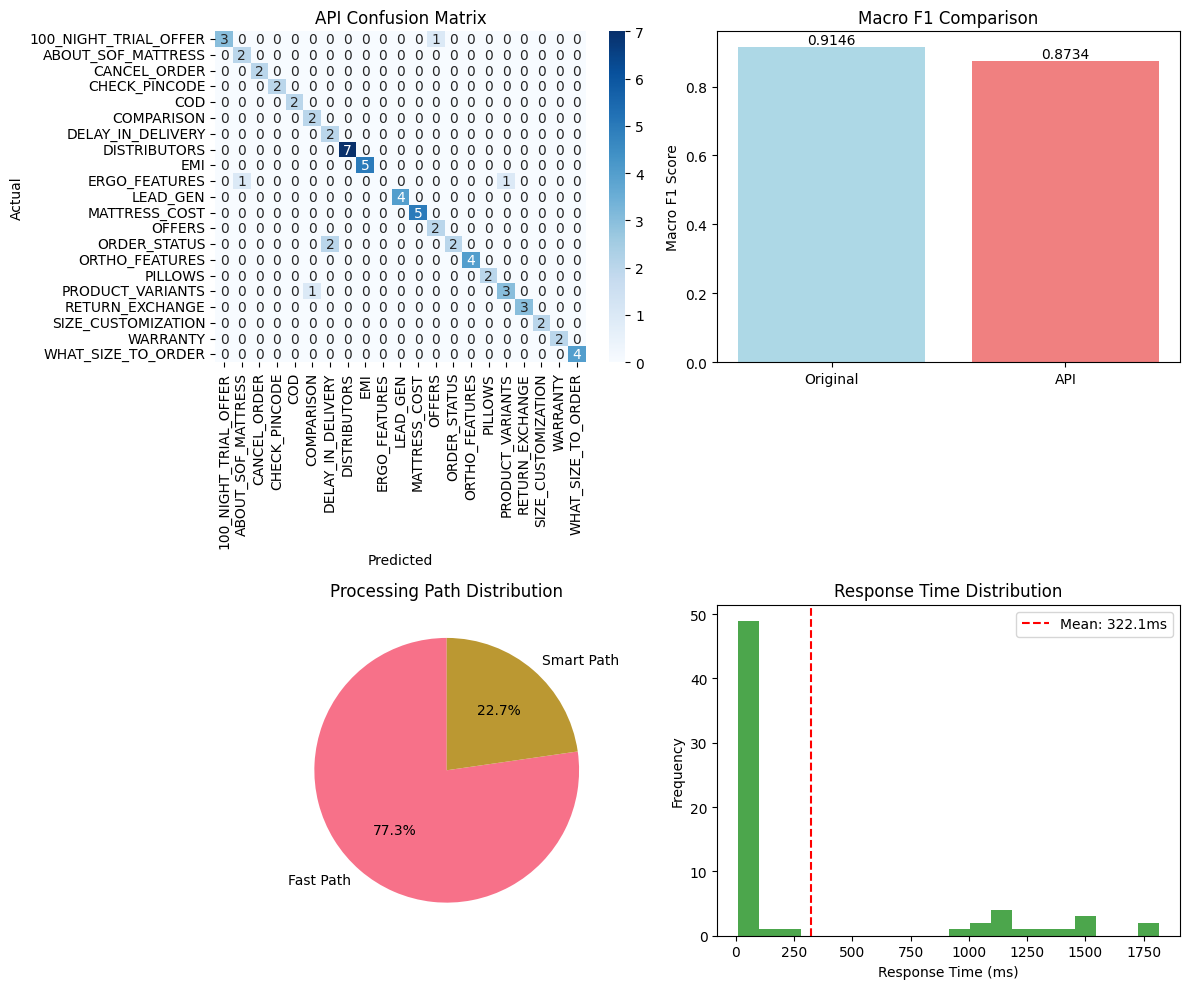

In [18]:
# ## Test Set Inference & Evaluation

import requests
from sklearn.metrics import classification_report, confusion_matrix, f1_score

# API endpoint
API_URL = "http://127.0.0.1:8080/detect"

# Run inference on test set
print("Running inference on test set...")
api_predictions = []
api_confidences = []
processing_paths = []
response_times = []

for i, text in enumerate(test_texts):
    try:
        response = requests.post(
            API_URL,
            headers={"Content-Type": "application/json"},
            json={"query": text},
            timeout=10
        )
        
        if response.status_code == 200:
            result = response.json()
            api_predictions.append(result['intent'])
            api_confidences.append(result['confidence'])
            processing_paths.append(result['processing_path'])
            response_times.append(result['response_time_ms'])
        else:
            print(f"Error for sample {i}: {response.status_code}")
            api_predictions.append("ERROR")
            api_confidences.append(0.0)
            processing_paths.append("error")
            response_times.append(0.0)
            
    except Exception as e:
        print(f"Exception for sample {i}: {str(e)}")
        api_predictions.append("ERROR")
        api_confidences.append(0.0)
        processing_paths.append("error")
        response_times.append(0.0)
    
    if (i + 1) % 10 == 0:
        print(f"Processed {i + 1}/{len(test_texts)} samples")

print(f"Completed inference on {len(test_texts)} samples")

# Calculate metrics
api_predictions = np.array(api_predictions)
valid_predictions = api_predictions != "ERROR"
valid_y_test = np.array(y_test)[valid_predictions]
valid_api_pred = api_predictions[valid_predictions]

if len(valid_api_pred) > 0:
    # Performance metrics
    api_macro_f1 = f1_score(valid_y_test, valid_api_pred, average='macro')
    api_micro_f1 = f1_score(valid_y_test, valid_api_pred, average='micro')
    api_weighted_f1 = f1_score(valid_y_test, valid_api_pred, average='weighted')
    
    print(f"\nAPI Performance Metrics:")
    print(f"  Macro F1:    {api_macro_f1:.4f}")
    print(f"  Micro F1:    {api_micro_f1:.4f}")
    print(f"  Weighted F1: {api_weighted_f1:.4f}")
    
    # Compare with original model
    print(f"\nComparison with Original Model:")
    print(f"  Original Macro F1: {f1_scores['macro_f1']:.4f}")
    print(f"  API Macro F1:      {api_macro_f1:.4f}")
    print(f"  Difference:        {api_macro_f1 - f1_scores['macro_f1']:.4f}")
    
    # Processing path analysis
    processing_paths = np.array(processing_paths)[valid_predictions]
    fast_count = np.sum(processing_paths == "fast")
    smart_count = np.sum(processing_paths == "smart")
    
    print(f"\nProcessing Path Analysis:")
    print(f"  Fast path (high confidence):  {fast_count} ({fast_count/len(processing_paths)*100:.1f}%)")
    print(f"  Smart path (LLM assisted):    {smart_count} ({smart_count/len(processing_paths)*100:.1f}%)")
    
    # Response time analysis
    valid_response_times = np.array(response_times)[valid_predictions]
    fast_times = valid_response_times[processing_paths == "fast"]
    smart_times = valid_response_times[processing_paths == "smart"]
    
    print(f"\nResponse Time Analysis:")
    print(f"  Overall average: {np.mean(valid_response_times):.1f} ms")
    if len(fast_times) > 0:
        print(f"  Fast path avg:   {np.mean(fast_times):.1f} ms")
    if len(smart_times) > 0:
        print(f"  Smart path avg:  {np.mean(smart_times):.1f} ms")
    
    # Confidence analysis
    valid_confidences = np.array(api_confidences)[valid_predictions]
    
    print(f"\nConfidence Analysis:")
    print(f"  Average confidence: {np.mean(valid_confidences):.3f}")
    print(f"  High confidence (>0.75): {np.sum(valid_confidences > 0.75)} ({np.sum(valid_confidences > 0.75)/len(valid_confidences)*100:.1f}%)")
    print(f"  Low confidence (≤0.75):  {np.sum(valid_confidences <= 0.75)} ({np.sum(valid_confidences <= 0.75)/len(valid_confidences)*100:.1f}%)")
    
    # Plot results
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # Confusion matrix
    cm = confusion_matrix(valid_y_test, valid_api_pred, labels=class_names)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names, ax=axes[0,0])
    axes[0,0].set_title('API Confusion Matrix')
    axes[0,0].set_xlabel('Predicted')
    axes[0,0].set_ylabel('Actual')
    
    # F1 comparison
    f1_comparison = ['Original', 'API']
    f1_values = [f1_scores['macro_f1'], api_macro_f1]
    axes[0,1].bar(f1_comparison, f1_values, color=['lightblue', 'lightcoral'])
    axes[0,1].set_title('Macro F1 Comparison')
    axes[0,1].set_ylabel('Macro F1 Score')
    for i, v in enumerate(f1_values):
        axes[0,1].text(i, v + 0.01, f'{v:.4f}', ha='center')
    
    # Processing path distribution
    path_counts = [fast_count, smart_count]
    path_labels = ['Fast Path', 'Smart Path']
    axes[1,0].pie(path_counts, labels=path_labels, autopct='%1.1f%%', startangle=90)
    axes[1,0].set_title('Processing Path Distribution')
    
    # Response time distribution
    axes[1,1].hist(valid_response_times, bins=20, alpha=0.7, color='green')
    axes[1,1].set_title('Response Time Distribution')
    axes[1,1].set_xlabel('Response Time (ms)')
    axes[1,1].set_ylabel('Frequency')
    axes[1,1].axvline(np.mean(valid_response_times), color='red', linestyle='--', 
                      label=f'Mean: {np.mean(valid_response_times):.1f}ms')
    axes[1,1].legend()
    
    plt.tight_layout()
    plt.show()
    
else:
    print("No valid predictions received from API")